<a href="https://colab.research.google.com/github/titobi/Brain-Tumor-Image-Classfication/blob/main/Brain-Tumor-Image-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip uninstall -y tensorflow keras tf-keras

!pip install tensorflow==2.15 keras==2.15

# Import necessary libraries
import os,glob,sys
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn import model_selection, metrics, preprocessing
from tqdm import tqdm
import pandas as pd
from keras.utils import to_categorical
from keras.applications.resnet import ResNet50

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: tf_keras 2.15.1
Uninstalling tf_keras-2.15.1:
  Successfully uninstalled tf_keras-2.15.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


!unzip "/content/drive/MyDrive/Brain_MRI.zip" -d "/content/drive/MyDrive/imgs/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-g

In [3]:

test_path = "/content/drive/MyDrive/imgs/Testing/"
train_path = "/content/drive/MyDrive/imgs/Training/"

In [4]:
# Function to assign label to each image
def assign_label(img, tumor_type):
    return tumor_type
size = (224,224)

# Function to preprocess images and store data and labels
def make_data(tumor_type, dir, X, y):
    for img in tqdm(os.listdir(dir)):
        label = assign_label(img, tumor_type)
        path = os.path.join(dir, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size))  # Resize to the input size expected by the model
        X.append(np.array(img))
        y.append(str(label))
    return X, y


In [5]:
X_train = []
y_train = []

pituitary_train = "/content/drive/MyDrive/imgs/Training/pituitary/"
notumor_train = "/content/drive/MyDrive/imgs/Training/notumor/"
meningioma_train = "/content/drive/MyDrive/imgs/Training/meningioma/"
glioma_train = "/content/drive/MyDrive/imgs/Training/glioma/"


In [6]:
X_test = []
y_test = []

pituitary_test = "/content/drive/MyDrive/imgs/Testing/pituitary/"
notumor_test = "/content/drive/MyDrive/imgs/Testing/notumor/"
meningioma_test = "/content/drive/MyDrive/imgs/Testing/meningioma/"
glioma_test = "/content/drive/MyDrive/imgs/Testing/glioma/"

In [7]:
# Preprocess training images and store data and labels
X_train, y_train = make_data('Glioma', glioma_train, X_train, y_train)
X_train, y_train = make_data('Meningioma', meningioma_train, X_train, y_train)
X_train, y_train = make_data('Notumor', notumor_train, X_train, y_train)
X_train, y_train = make_data('Pituitary', pituitary_train, X_train, y_train)



100%|██████████| 1457/1457 [00:17<00:00, 85.05it/s] 


In [8]:
# Preprocess test images and store data and labels
X_test, y_test = make_data('Glioma', glioma_test, X_test, y_test)
X_test, y_test = make_data('Meningioma', meningioma_test, X_test, y_test)
X_test, y_test = make_data('Notumor', notumor_test, X_test, y_test)
X_test, y_test = make_data('Pituitary', pituitary_test, X_test, y_test)

100%|██████████| 300/300 [00:02<00:00, 138.53it/s]


In [9]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# One-hot encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes=len(np.unique(y_train)))

y_test = le.transform(y_test)
y_test = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Check the new shapes
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (5712, 224, 224, 3)
Test data shape: (1311, 224, 224, 3)


In [11]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (5712, 224, 224, 3)
Training labels shape: (5712, 4)
Test data shape: (1311, 224, 224, 3)
Test labels shape: (1311, 4)


In [12]:
def show_sample_images(X, y, class_names, num_samples=3):
  plt.figure(figsize=(15, 10))
  for i, class_name in enumerate(class_names):
        class_indices = np.where(np.argmax(y, axis=1) == i)[0]
        sample_indices = class_indices[:num_samples]
        for j, idx in enumerate(sample_indices):
            img = X[idx]  # Reshape if necessary
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(class_name)
            plt.axis('off')
  plt.show()

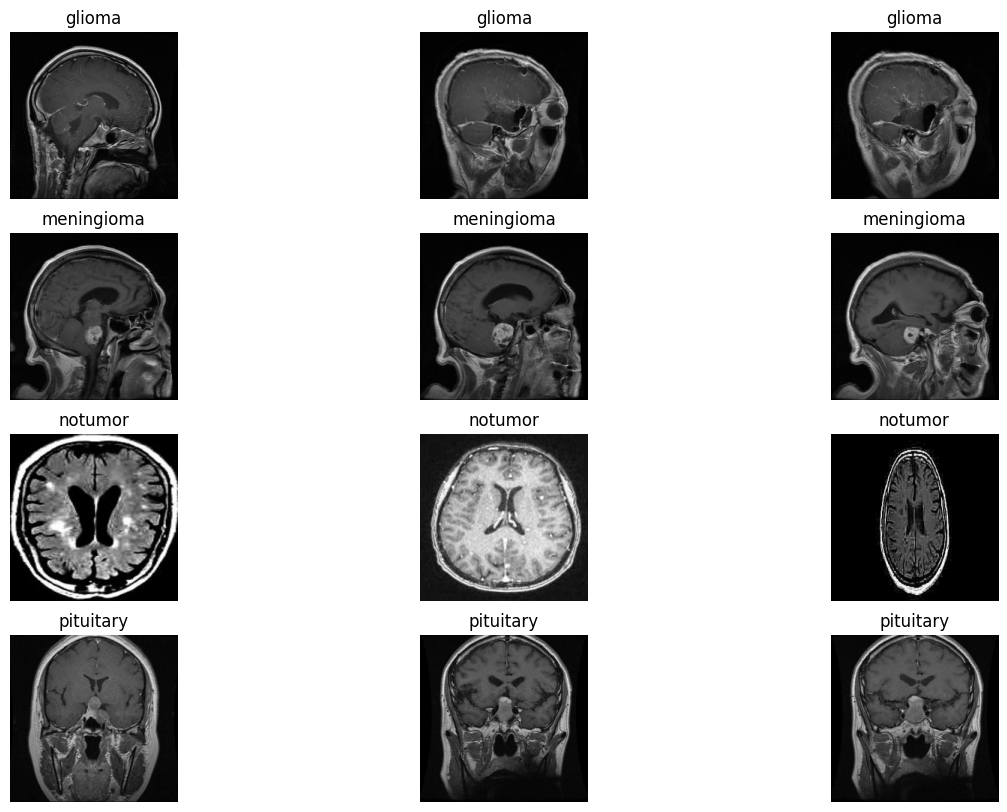

In [13]:
# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Visualize training data
show_sample_images(X_train, y_train, class_names)


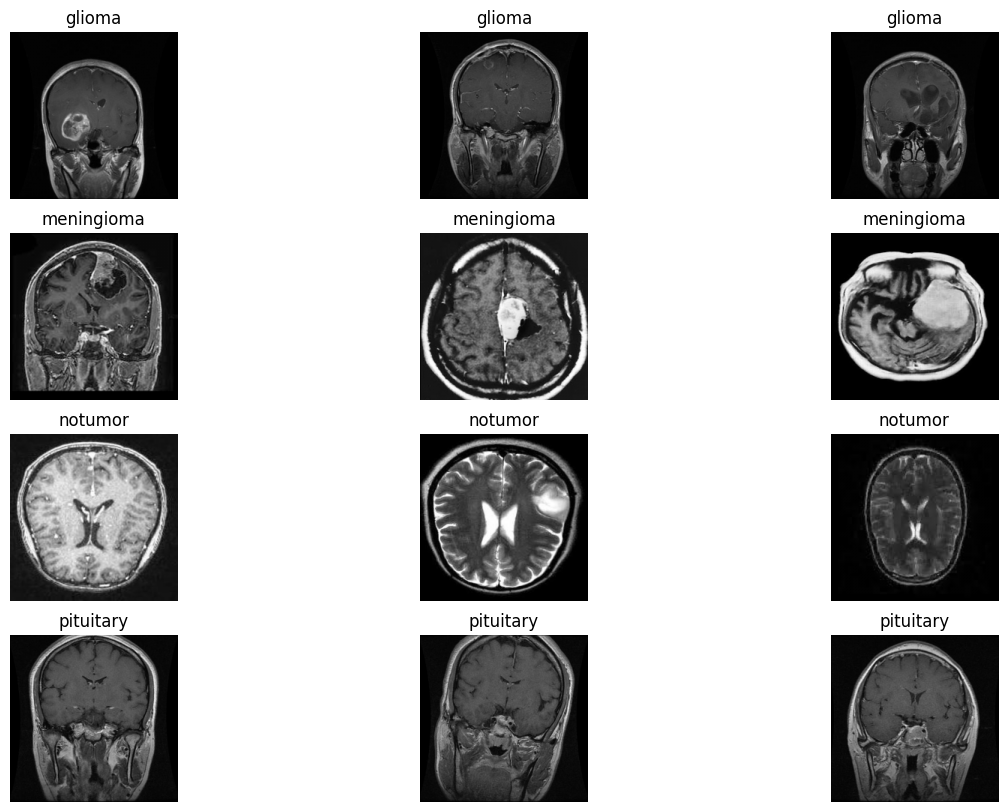

In [14]:
# Visualize test data
show_sample_images(X_test, y_test, class_names)

In [15]:
#Check the number of images in each class
def images_in_classes(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

train_count = images_in_classes(train_path)
test_count = images_in_classes(test_path)
print("Training class counts:", train_count)
print("Testing class counts:", test_count)

Training class counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing class counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


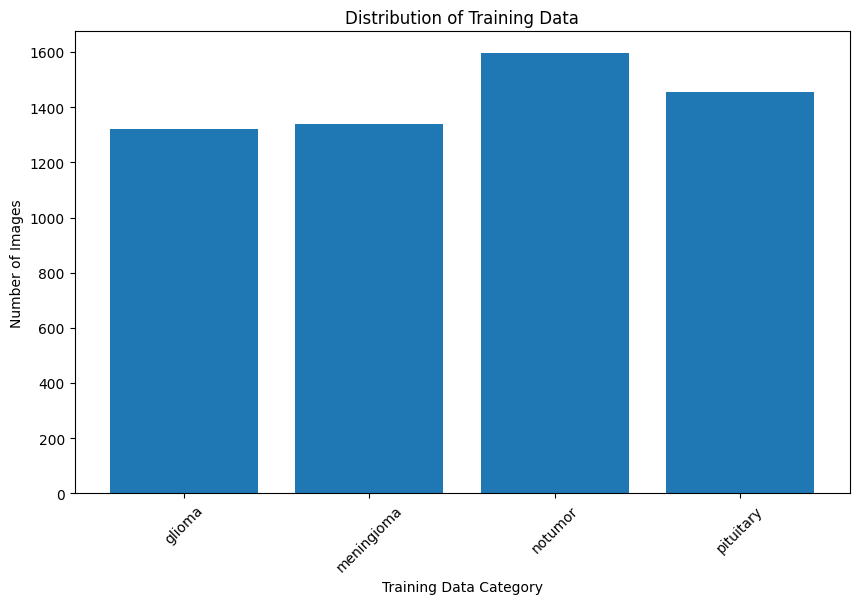

In [16]:
 # Create a bar chart showing the distribution of Train data
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Training Data Category')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show
plot_class_distribution(train_count, 'Distribution of Training Data')




In [17]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Create generators to load and preprocess the images
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size= size,
    batch_size=32,
    class_mode='categorical',

)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size= size,
    batch_size=32,
    class_mode='categorical',

)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [19]:
# Print class indices
print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

#verify images and labels are loaded correctly
images, labels = next(train_generator)
print("Batch shape:", images.shape, labels.shape)

Train classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Batch shape: (32, 224, 224, 3) (32, 4)


In [20]:


# Load the VGG16 model
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


58889256/58889256 [==============================] - 0s 0us/step


In [21]:
# Define the model
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes

# Freeze the base model
base_model.trainable = False


In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 14847044 (56.64 MB)
Trainable params: 132356 (517.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [23]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output_shape)

X_train shape: (5712, 224, 224, 3)
y_train shape: (5712, 4)
Model output shape: (None, 4)


In [24]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
179/179 [==============================] - 47s 210ms/step - loss: 1.3657 - accuracy: 0.3682 - val_loss: 1.1244 - val_accuracy: 0.6201
Epoch 2/10
179/179 [==============================] - 27s 148ms/step - loss: 1.0766 - accuracy: 0.5716 - val_loss: 0.9722 - val_accuracy: 0.6834
Epoch 3/10
179/179 [==============================] - 27s 152ms/step - loss: 0.9040 - accuracy: 0.6900 - val_loss: 0.8740 - val_accuracy: 0.6918
Epoch 4/10
179/179 [==============================] - 29s 161ms/step - loss: 0.8027 - accuracy: 0.7288 - val_loss: 0.8017 - val_accuracy: 0.7178
Epoch 5/10
179/179 [==============================] - 28s 157ms/step - loss: 0.7334 - accuracy: 0.7598 - val_loss: 0.7503 - val_accuracy: 0.7384
Epoch 6/10
179/179 [==============================] - 28s 155ms/step - loss: 0.6745 - accuracy: 0.7803 - val_loss: 0.7067 - val_accuracy: 0.7506
Epoch 7/10
179/179 [==============================] - 28s 158ms/step - loss: 0.6305 - accuracy: 0.7936 - val_loss: 0.6792 - val_ac

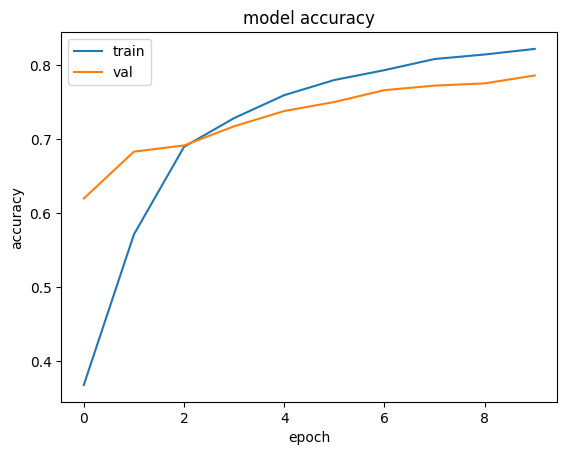

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

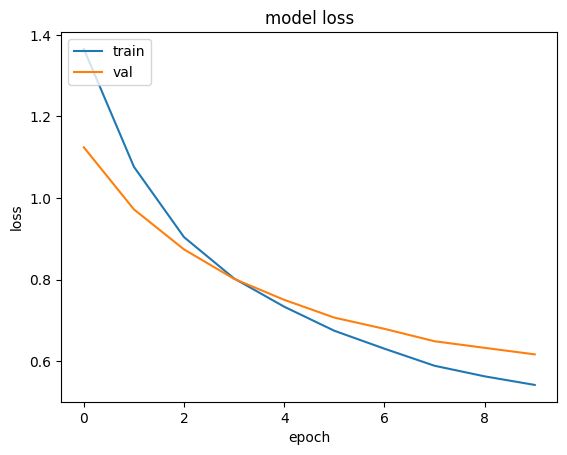

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


41/41 [==============================] - 6s 131ms/step - loss: 0.6180 - accuracy: 0.7879
Test loss: 0.6179556846618652
Test accuracy: 0.7879481315612793


In [28]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 5s 124ms/step
              precision    recall  f1-score   support

      glioma       0.75      0.80      0.78       300
  meningioma       0.69      0.47      0.56       306
     notumor       0.88      0.89      0.88       405
   pituitary       0.77      0.96      0.85       300

    accuracy                           0.79      1311
   macro avg       0.77      0.78      0.77      1311
weighted avg       0.78      0.79      0.78      1311

[[240  43   4  13]
 [ 53 144  43  66]
 [ 19  19 360   7]
 [  7   3   3 287]]


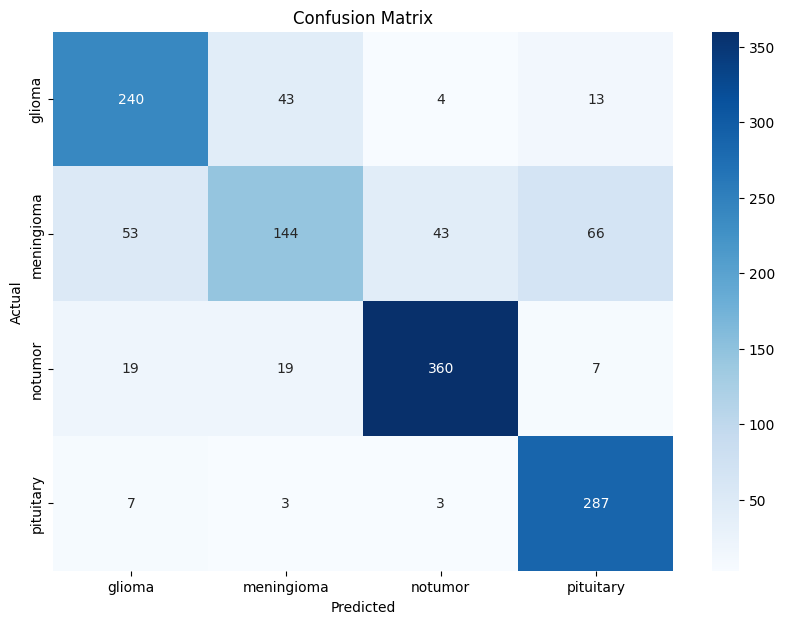

In [29]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [30]:
base_model = tf.keras.applications.resnet.ResNet50(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


94765736/94765736 [==============================] - 0s 0us/step


In [31]:
model = Sequential()
model.add(base_model)

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes



In [32]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24113284 (91.98 MB)
Trainable params: 24060164 (91.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [34]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
179/179 [==============================] - 105s 387ms/step - loss: 0.2748 - accuracy: 0.9009 - val_loss: 3.4340 - val_accuracy: 0.3089
Epoch 2/10
179/179 [==============================] - 60s 335ms/step - loss: 0.0670 - accuracy: 0.9781 - val_loss: 3.3611 - val_accuracy: 0.3043
Epoch 3/10
179/179 [==============================] - 60s 335ms/step - loss: 0.0426 - accuracy: 0.9879 - val_loss: 3.6262 - val_accuracy: 0.3234
Epoch 4/10
179/179 [==============================] - 60s 335ms/step - loss: 0.0388 - accuracy: 0.9874 - val_loss: 4.4443 - val_accuracy: 0.3684
Epoch 5/10
179/179 [==============================] - 60s 335ms/step - loss: 0.0159 - accuracy: 0.9937 - val_loss: 1.9915 - val_accuracy: 0.5683
Epoch 6/10
179/179 [==============================] - 60s 334ms/step - loss: 0.0153 - accuracy: 0.9963 - val_loss: 0.1939 - val_accuracy: 0.9352
Epoch 7/10
179/179 [==============================] - 60s 335ms/step - loss: 0.0369 - accuracy: 0.9888 - val_loss: 0.5572 - val_a

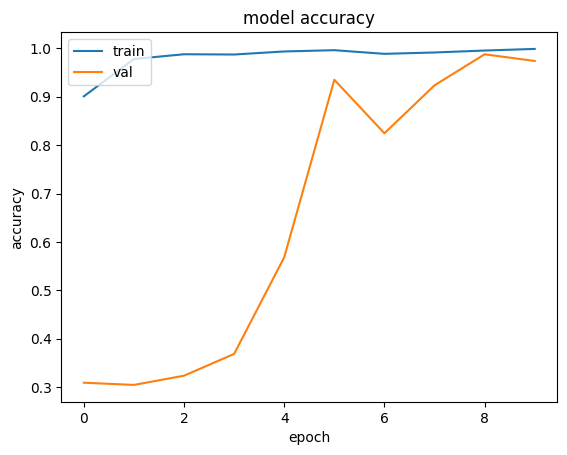

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

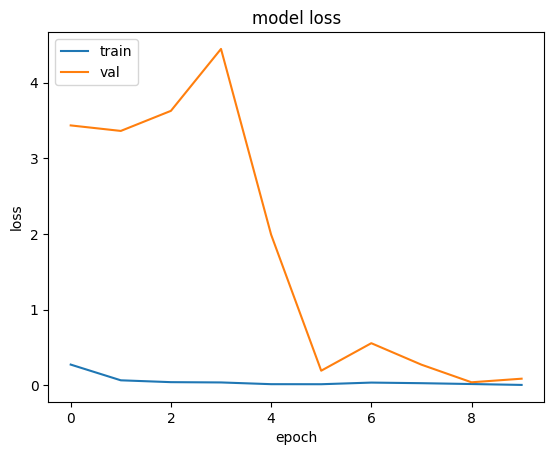

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


41/41 [==============================] - 6s 132ms/step - loss: 0.0863 - accuracy: 0.9756
Test loss: 0.0862564891576767
Test accuracy: 0.9755911231040955


In [38]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 5s 93ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       300
  meningioma       0.98      0.91      0.94       306
     notumor       0.95      1.00      0.97       405
   pituitary       1.00      0.98      0.99       300

    accuracy                           0.97      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

[[298   2   0   0]
 [  5 279  21   1]
 [  0   0 405   0]
 [  1   4   0 295]]


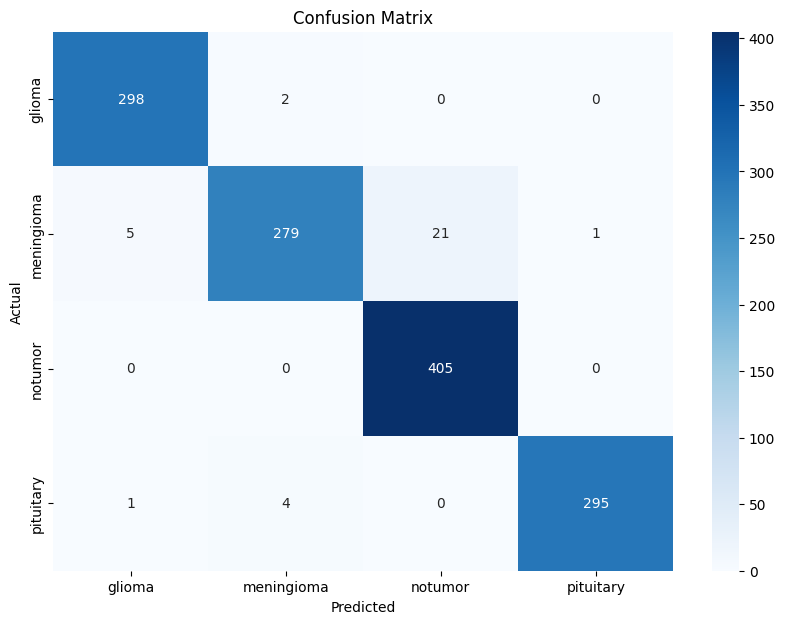

In [39]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
